# Метрики TF-IDF для любых 10 песен

In [ ]:
# !pip install pymorphy3
# !pip install transformers

In [37]:
import os # работа с папкой и файлами
import re # регулярные выражения, доп вариант к очистке
import string # работа со строкой
import math
import operator
import random
import time

import numpy as np
import pandas as pd # работа с таблицей dataframe

import nltk # работа с пакетами языков
from nltk import word_tokenize, ngrams # токенизация и деление на n граммы
from nltk.corpus import stopwords # стопслова, extend

from wordcloud import WordCloud # визуальное отображение
import pymorphy3 # работа с русским языком, pymorphy3

import matplotlib.pyplot as plt # визуальное отображение
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# скачаем словарь стоп-слов
nltk.download("stopwords")

# скачиваем модель, которая будет делить на предложения
nltk.download('punkt')

from sklearn.model_selection import train_test_split # Деление выборки на тестовые и тренировочные данные

# python -m pip install transformers
from transformers import BertTokenizer # токенизатор BERT
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

# python -m pip install tensorflow
# python -m pip install torch torchvision torchaudio
import tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score # Критерий качества, точности

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorokin.m.e\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sorokin.m.e\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !wget 'https://raw.githubusercontent.com/SotGE/innopolis2023/main/lesson13/data.zip'
# !unzip '/data/data.zip'

In [3]:
# Список файлов в папке
FOLDER_NAME = 'data'

direct_list = os.listdir(FOLDER_NAME)
direct_list

['Ария - Возьми мое сердце.txt',
 'Григорий Лепс - Самый лучший день.txt',
 'Земляне - Земля в иллюминаторе.txt',
 'Кино - Пачка сигарет.txt',
 'Кипелов - Я Свободен.txt',
 'Король и Шут - Лесник.txt',
 'Любэ - Берёзы.txt',
 'Любэ - Ты неси меня река.txt',
 'Наутилус Помпилиус - Прогулки по воде.txt',
 'Руки Вверх - Крошка моя.txt']

In [4]:
# Имена песен из названия файлов
names = [song.replace(".txt", "") for song in direct_list]
names

['Ария - Возьми мое сердце',
 'Григорий Лепс - Самый лучший день',
 'Земляне - Земля в иллюминаторе',
 'Кино - Пачка сигарет',
 'Кипелов - Я Свободен',
 'Король и Шут - Лесник',
 'Любэ - Берёзы',
 'Любэ - Ты неси меня река',
 'Наутилус Помпилиус - Прогулки по воде',
 'Руки Вверх - Крошка моя']

In [5]:
# Функция чтения файла
def read_song(filename, folder=FOLDER_NAME):
  text = ''
  with open(f'{folder}/{filename}.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    text = text.replace('\n', ' ')
  return text

# Чтение данных из папки
songs_list = []

for song in names:
  songs_list.append(read_song(song))

songs_list

['Слепая ночь легла у ног И не пускает на порог. Брожу по дому как во сне, Но мне покоя нет нигде. Тупая боль пробьет висок, И пальцы лягут на курок, А в зеркалах качнется призрак, Призрак любви...  Возьми мое сердце, Возьми мою душу. Я так одинок в этот час, Что хочу умереть... Мне некуда деться, Свой мир я разрушил. По мне плачет только свеча, На холодной заре.  Ты умерла в дождливый день И тени плыли по воде Я смерть увидел в первый раз Ее величие и грязь В твоих глазах застыла боль, Я разделю ее с тобой. А в зеркалах качнется призрак, Призрак любви...  Возьми мое сердце, Возьми мою душу. Я так одинок в этот час, Что хочу умереть... Мне некуда деться, Свой мир я разрушил. По мне плачет только свеча, На холодной заре.  Я слышу утренний колокол - Он славит праздник, И сыпет медью и золотом. Ты теперь в царстве вечного сна.  Я слышу утренний колокол - Он бесов дразнит, И звоном небо расколото. На земле я любил лишь тебя...  Я слышу утренний колокол - Он славит праздник, И сыпет медью и

In [6]:
# Стоп-слова русского языка
stopwords_list = stopwords.words("russian")

# Собственные стоп-слова
extra_stop = ['твоей', 'свои', 'тобой', 'мой', 'твой', 'мой', 'это']
stopwords_list.extend(extra_stop)

len(stopwords_list)

158

In [7]:
# Очищение строк
def clean_string(text):
  string.punctuation += '—'
  text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!|…', text)
  text = ' '.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stopwords_list])
  return text

songs_list_сlean = [clean_string(song) for song in songs_list]
songs_list_сlean

['слепая ночь легла ног пускает порог брожу дому сне покоя нигде тупая боль пробьет висок пальцы лягут курок зеркалах качнется призрак призрак любви возьми мое сердце возьми мою душу одинок час хочу умереть некуда деться свой мир разрушил плачет свеча холодной заре умерла дождливый день тени плыли воде смерть увидел первый величие грязь твоих глазах застыла боль разделю зеркалах качнется призрак призрак любви возьми мое сердце возьми мою душу одинок час хочу умереть некуда деться свой мир разрушил плачет свеча холодной заре слышу утренний колокол славит праздник сыпет медью золотом царстве вечного сна слышу утренний колокол бесов дразнит звоном небо расколото земле любил лишь слышу утренний колокол славит праздник сыпет медью золотом царстве вечного сна слышу утренний колокол бесов дразнит звоном небо расколото земле любил лишь возьми мое сердце',
 'триста тысяч часов спиною триста тысяч планет мною устал создатель небе кружить каждый просыпаясь рассветом неспроста вспоминаешь очень зд

In [8]:
# Приводим слова к начальной форме
# py -m pip install pymorphy3-dicts-ru
morph = pymorphy3.MorphAnalyzer(lang='ru')

def normilize_word(text):
  words = text.split() # по пробелу разделить
  result_list = []
  for word in words:
    # print(morph.parse(word))
    normal_form = morph.parse(word)[0].normal_form
    result_list.append(normal_form)
    # print(normal_form)
  return " ".join(result_list)

songs_list_norm = [normilize_word(song) for song in songs_list_сlean]
songs_list_norm

['слепой ночь лечь нога пускать порог бродить дом сон покой нигде тупой боль пробить висок палец лечь курок зеркало качнуться призрак призрак любовь взять мой сердце взять мой душа одинокий час хотеть умереть некуда деться свой мир разрушить плакать свеча холодный заря умереть дождливый день тень плыть вода смерть увидеть первый величие грязь твой глаз застылый боль разделить зеркало качнуться призрак призрак любовь взять мой сердце взять мой душа одинокий час хотеть умереть некуда деться свой мир разрушить плакать свеча холодный заря слышать утренний колокол славить праздник сыпать медь золото царство вечный сон слышать утренний колокол бес дразнить звон небо расколоть земля любить лишь слышать утренний колокол славить праздник сыпать медь золото царство вечный сон слышать утренний колокол бес дразнить звон небо расколоть земля любить лишь взять мой сердце',
 'триста тысяча час спина триста тысяча планета я устать создатель небо кружить каждый просыпаться рассвет неспроста вспоминать 

In [9]:
# Имена и песни заносим во фрейм
df = pd.DataFrame({'name': names, 'song_text': songs_list_norm})
df.head()

,name,song_text
0,Ария - Возьми мое сердце,слепой ночь лечь нога пускать порог бродить до...
1,Григорий Лепс - Самый лучший день,триста тысяча час спина триста тысяча планета ...
2,Земляне - Земля в иллюминаторе,земля иллюминатор земля иллюминатор земля иллю...
3,Кино - Пачка сигарет,сидеть смотреть чужое небо чужое окно видеть о...
4,Кипелов - Я Свободен,я тишина небо полный дождь дождь пpоходить скв...


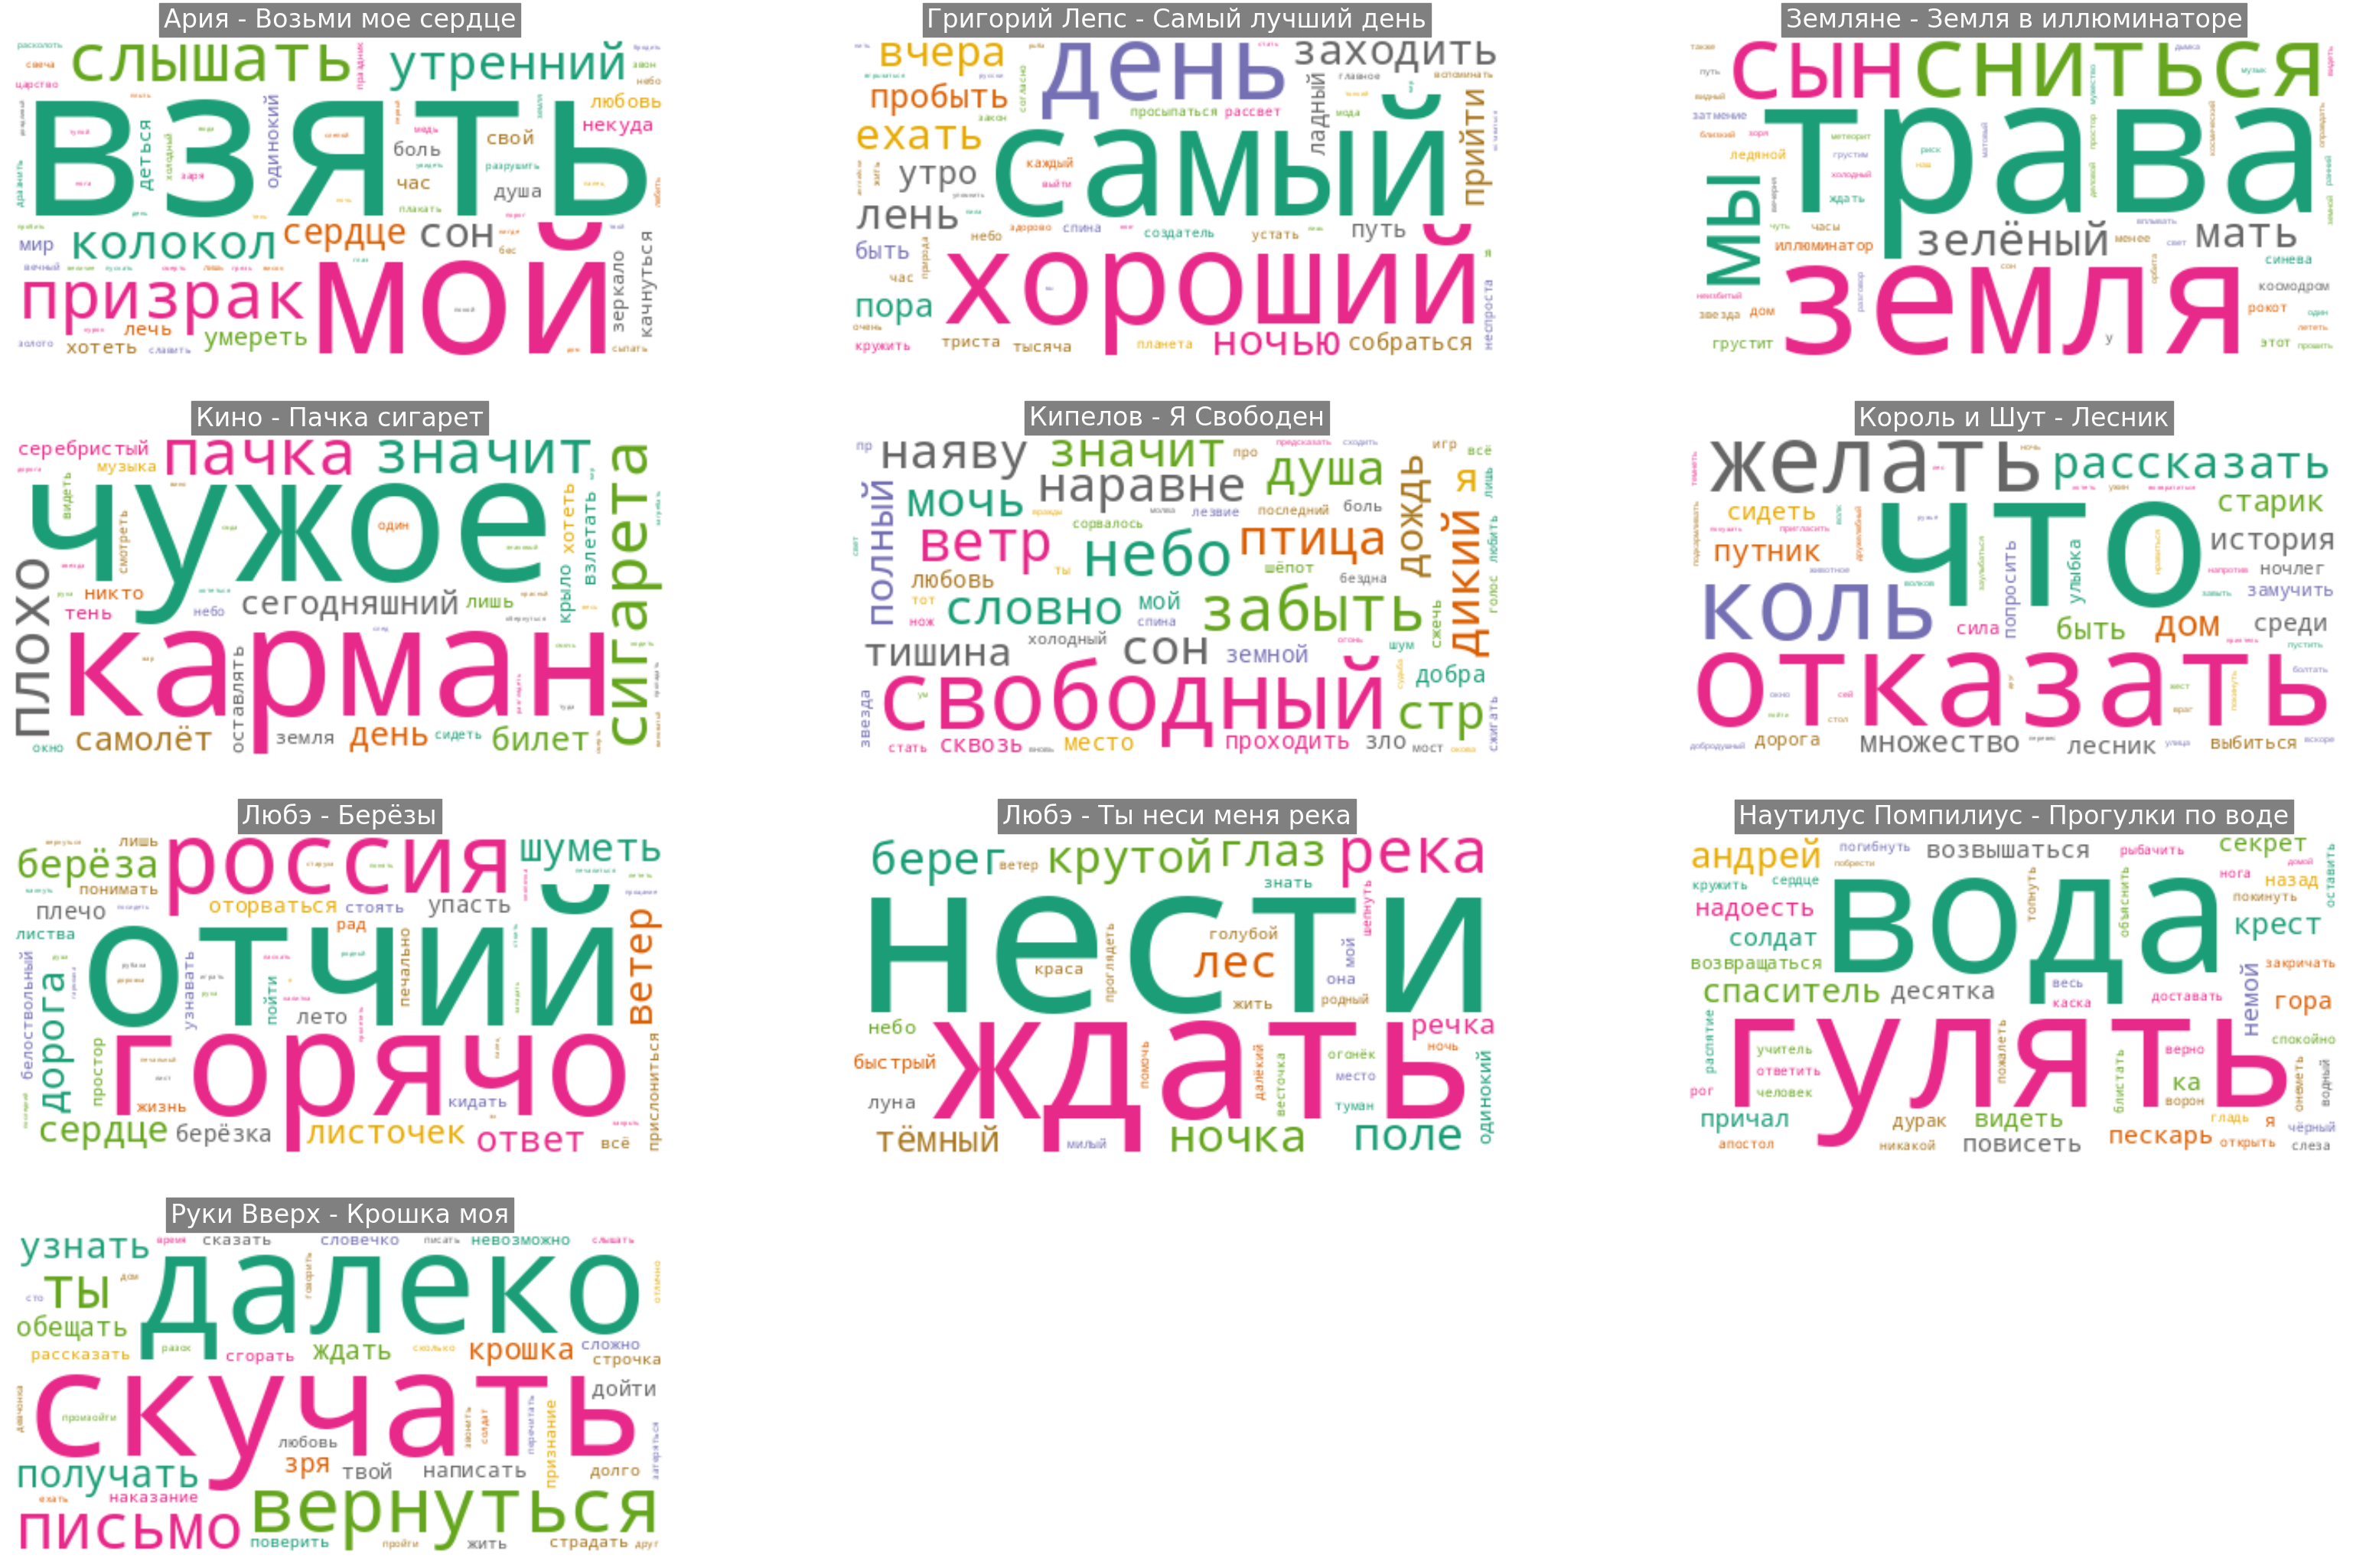

In [10]:
# График в виде "облако слов"
plt.rcParams["figure.figsize"] = [40, 80]
fig = plt.figure()
i = 1
col = 3
row = math.ceil(len(df)/col)*3
for name, text in zip(df.name, df.song_text):
  tokens = word_tokenize(text)
  text_raw = " ".join(tokens)
  wordcloud = WordCloud(
    colormap='Dark2',
    background_color='white',
    contour_width=10,
    random_state=1,
    margin=10,
    collocations=False
  ).generate(text_raw)
  plt.subplot(row, col, i, label=name, frameon=True)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(name, fontdict={'fontsize':24,'color':'white', 'backgroundcolor': 'grey'}, y=1)
  i += 1

In [11]:
# Облако слов
wordcloud.layout_

[(('скучать', 1.0), 89, (88, 10), None, 'rgb(231, 41, 138)'),
 (('далеко', 0.9090909090909091), 85, (16, 79), None, 'rgb(27, 158, 119)'),
 (('вернуться', 0.9090909090909091),
  46,
  (158, 145),
  None,
  'rgb(102, 166, 30)'),
 (('письмо', 0.6363636363636364), 38, (172, 5), None, 'rgb(231, 41, 138)'),
 (('ты', 0.5454545454545454), 35, (29, 20), None, 'rgb(102, 166, 30)'),
 (('получать', 0.45454545454545453), 23, (143, 5), None, 'rgb(27, 158, 119)'),
 (('узнать', 0.45454545454545453), 22, (6, 7), None, 'rgb(27, 158, 119)'),
 (('крошка', 0.2727272727272727), 18, (69, 277), None, 'rgb(217, 95, 2)'),
 (('обещать', 0.2727272727272727), 16, (52, 5), None, 'rgb(102, 166, 30)'),
 (('ждать', 0.2727272727272727), 16, (70, 184), None, 'rgb(102, 166, 30)'),
 (('зря', 0.2727272727272727), 16, (138, 166), None, 'rgb(217, 95, 2)'),
 (('написать', 0.18181818181818182),
  13,
  (143, 250),
  None,
  'rgb(102, 102, 102)'),
 (('твой', 0.18181818181818182), 13, (141, 201), None, 'rgb(102, 102, 102)'),
 ((

In [12]:
# Создание объекта TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(songs_list_norm)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['взять', 'утренний', 'призрак', 'колокол', 'мой', 'слышать', 'умереть', 'сон', 'сердце', 'царство', 'сыпать', 'славить', 'свой', 'свеча', 'расколоть', 'разрушить', 'праздник', 'плакать', 'некуда', 'медь', 'лечь', 'качнуться', 'золото', 'зеркало', 'звон', 'заря', 'дразнить', 'деться', 'вечный', 'бес', 'час', 'одинокий', 'любить', 'боль', 'хотеть', 'холодный', 'мир', 'любовь', 'земля', 'душа', 'небо', 'лишь', 'увидеть', 'тупой', 'слепой', 'разделить', 'пускать', 'пробить', 'порог', 'покой', 'плыть', 'первый', 'нигде', 'курок', 'застылый', 'дождливый', 'грязь', 'висок', 'величие', 'бродить', 'тень', 'твой', 'смерть', 'палец', 'нога', 'глаз', 'вода', 'ночь', 'день', 'дом', 'эх', 'этот', 'шёпот', 'шуметь', 'шум', 'шепнуть', 'чёрный', 'чужое', 'что', 'человек', 'часы', 'чyть', 'хотеться', 'хороший', 'ходить', 'учитель', 'утро', 'устать', 'упомнить', 'упасть', 'ум', 'улыбка', 'улица', 'узнать', 'узнавать', 'ужин', 'тёмный', 'тысяча', 'ты', 'туман', 'туда', 'триста', 'трава', 

In [13]:
# Список ключевых слов
feature_names

array(['wow', 'английски', 'андрей', 'апостол', 'бездна', 'белоствольный',
       'берег', 'берёза', 'берёзка', 'бес', 'билет', 'близкий',
       'блистать', 'болтать', 'боль', 'бродить', 'быстрый', 'быть',
       'вpажды', 'вгрызаться', 'величие', 'верно', 'вернуться',
       'весточка', 'весь', 'ветp', 'ветер', 'вечерня', 'вечный',
       'взлетать', 'взять', 'видеть', 'видный', 'вино', 'виноватый',
       'висок', 'вновь', 'вода', 'водный', 'возвратиться', 'возвращаться',
       'возвышаться', 'волк', 'волков', 'ворон', 'вплывать', 'враг',
       'время', 'вскоре', 'вспоминать', 'всё', 'вчера', 'выбиться',
       'выйти', 'гармошка', 'главное', 'гладь', 'глаз', 'говорить',
       'голос', 'голубой', 'гора', 'горячо', 'грyстим', 'грyстит',
       'грязь', 'гулять', 'далеко', 'далёкий', 'девчонка', 'деловой',
       'день', 'десятка', 'деться', 'дикий', 'добpа', 'добродушный',
       'дождливый', 'дождь', 'дойти', 'долго', 'дом', 'домой', 'дорога',
       'дорожка', 'доставать', 'драз

In [14]:
# Значение ключевых слов
df = pd.DataFrame(tfidf_scores, columns=['TF-IDF'])
df.head(20)

,TF-IDF
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.125588


In [15]:
# Ограничение количества признаков
count_vectorizer = CountVectorizer()
bow = count_vectorizer.fit_transform(songs_list_norm)
print(bow.shape)
vocab_sorted = sorted(count_vectorizer.vocabulary_.items(), key=operator.itemgetter(0))
vocab_sorted

(10, 439)


[('wow', 0),
 ('английски', 1),
 ('андрей', 2),
 ('апостол', 3),
 ('бездна', 4),
 ('белоствольный', 5),
 ('берег', 6),
 ('берёза', 7),
 ('берёзка', 8),
 ('бес', 9),
 ('билет', 10),
 ('близкий', 11),
 ('блистать', 12),
 ('болтать', 13),
 ('боль', 14),
 ('бродить', 15),
 ('быстрый', 16),
 ('быть', 17),
 ('вpажды', 18),
 ('вгрызаться', 19),
 ('величие', 20),
 ('верно', 21),
 ('вернуться', 22),
 ('весточка', 23),
 ('весь', 24),
 ('ветp', 25),
 ('ветер', 26),
 ('вечерня', 27),
 ('вечный', 28),
 ('взлетать', 29),
 ('взять', 30),
 ('видеть', 31),
 ('видный', 32),
 ('вино', 33),
 ('виноватый', 34),
 ('висок', 35),
 ('вновь', 36),
 ('вода', 37),
 ('водный', 38),
 ('возвратиться', 39),
 ('возвращаться', 40),
 ('возвышаться', 41),
 ('волк', 42),
 ('волков', 43),
 ('ворон', 44),
 ('вплывать', 45),
 ('враг', 46),
 ('время', 47),
 ('вскоре', 48),
 ('вспоминать', 49),
 ('всё', 50),
 ('вчера', 51),
 ('выбиться', 52),
 ('выйти', 53),
 ('гармошка', 54),
 ('главное', 55),
 ('гладь', 56),
 ('глаз', 57),
 

In [16]:
# Биграммы, триграммы, n-граммы
count_vectorizer = CountVectorizer(ngram_range=(1,2),  min_df=2)
bow = count_vectorizer.fit_transform(songs_list_norm)
count_vectorizer.vocabulary_

{'ночь': 35,
 'нога': 34,
 'дом': 10,
 'сон': 53,
 'боль': 0,
 'палец': 39,
 'любовь': 27,
 'мой': 30,
 'сердце': 48,
 'душа': 13,
 'одинокий': 37,
 'час': 61,
 'хотеть': 60,
 'мир': 29,
 'холодный': 59,
 'день': 9,
 'тень': 57,
 'вода': 6,
 'смерть': 51,
 'твой': 56,
 'глаз': 8,
 'слышать': 50,
 'небо': 33,
 'земля': 18,
 'любить': 25,
 'лишь': 24,
 'мой душа': 31,
 'любить лишь': 26,
 'спина': 54,
 'кружить': 21,
 'жить': 16,
 'ехать': 14,
 'быть': 1,
 'мы': 32,
 'стать': 55,
 'один': 36,
 'звезда': 17,
 'ждать': 15,
 'свет': 47,
 'земной': 19,
 'видеть': 5,
 'лететь': 23,
 'простор': 43,
 'сидеть': 49,
 'окно': 38,
 'весь': 3,
 'дорога': 11,
 'значит': 20,
 'рука': 46,
 'последний': 42,
 'всё': 7,
 'ты': 58,
 'место': 28,
 'рассказать': 44,
 'покинуть': 41,
 'друг': 12,
 'пойти': 40,
 'лес': 22,
 'ветер': 4,
 'родный': 45,
 'вернуться': 2,
 'солдат': 52}

# Использование предварительно обученной модели BERT для классификации тональности отзывов на фильмы

In [17]:
# Чтение данных
df = pd.read_csv('https://raw.githubusercontent.com/SotGE/innopolis2023/main/lesson13/IMDB Dataset.csv', sep=',')
# df = pd.read_csv(f"IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [18]:
# Бинарная категоризация столбца "sentiment"
df.sentiment = pd.Categorical(df.sentiment)
df.sentiment = df.sentiment.cat.codes
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [19]:
# Разделим данные на тренировочные и тестовые
x = df['review']
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=15)

In [20]:
# Определим токенизатор BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
}

In [21]:
# Возьмем длину для Берта - 256
MAX_LEN = 128

def preprocessing_for_bert(data):
  """Препроцессинг на модели  BERT.
  @param    data (np.array): Текст для препроц.
  @return   input_ids (torch.Tensor): Либо id token, либо объект тензор.
  @return   attention_masks (torch.Tensor): Определяем набор токенов (объекты тензоры) для работы мехонизма внимания.
  """
  input_ids = []
  attention_masks = []
  for sent in data:
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    encoded_sent = tokenizer.encode_plus(
      sent,
      add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
      max_length=MAX_LEN,             # Max length to truncate/pad
      pad_to_max_length=True,         # Pad sentence to max length
      return_attention_mask=True      # Return attention mask
    )

    # Добавление обработанных (закодированных данных) в списки id, masks
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))
  # Преобразуем в тензоры
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

In [22]:
# Используем токенизатор BERT для подготовки тренировочных и тестовых данных для классификатора BERT
# Выполняем на T4 GPU
train_inputs, train_masks = preprocessing_for_bert(x_train)
test_inputs, test_masks = preprocessing_for_bert(x_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
train_masks

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])

In [24]:
train_inputs

tensor([[ 101, 1996, 8297,  ..., 3185, 2097,  102],
        [ 101, 2023, 2003,  ..., 3492, 3435,  102],
        [ 101, 1045, 2081,  ..., 2729, 2055,  102],
        ...,
        [ 101, 2028, 2052,  ..., 2021, 2009,  102],
        [ 101, 1045, 1005,  ..., 2122, 2024,  102],
        [ 101, 3849, 2000,  ...,    0,    0,    0]])

In [32]:
# Подготовим другие данные для использования в классификаторе BERT
# преобразуем объект Series в массив
if isinstance(y_train, pd.Series):
  y_train=y_train.to_numpy() # преобразуем объект Series в массив

if isinstance(y_test, pd.Series):
  y_test=y_test.to_numpy() # преобразуем объект Series в массив

train_labels = torch.LongTensor(y_train) # делаем из numpy array LongTensor
test_labels = torch.LongTensor(y_test) # делаем из numpy array LongTensor

batch_size = 16

# TensorDataset: входные данные (отзывы), маски для отзывов, с чем сравнивать
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# RandomSampler: входные данные (отзывы)
train_sampler = RandomSampler(train_data)
# RandomSampler: входные данные (отзывы), batch_size, RandomSampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [33]:
# Определим классификатор BERT
class BertClassifier(nn.Module):
  def __init__(self, freeze_bert=False):
    super(BertClassifier, self).__init__()

    D_in, H, D_out = 768, 50, 2

    self.bert = BertModel.from_pretrained('bert-base-uncased')

    self.classifier = nn.Sequential(
      nn.Linear(D_in, H),
      nn.ReLU(),
      #nn.Dropout(0.3),
      nn.Linear(H, D_out)
    )

    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    # Смотрим CLS
    last_hidden_state_cls = outputs[0][:, 0, :]

    logits = self.classifier(last_hidden_state_cls)
    return logits

In [42]:
# Инициализируем модель
EPOCH_NUM = 4
# device = torch.device("cuda")
device = torch.device("cpu")

def initialize_model(epochs=EPOCH_NUM):
  # экземпляр BertClassifier
  bert_classifier = BertClassifier(freeze_bert=False)

  # Задаем устройство (GPU T4)
  bert_classifier.to(device)

  # Create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
    lr=5e-5,    # learning rate
    eps=1e-8    # epsilon - точность функции, до какого значения считать
  )

  # Расчет циклов для работы
  total_steps = len(train_dataloader) * epochs

  # Загрузчик, расписание (последовательность) и число циклов для обучения
  scheduler = get_linear_schedule_with_warmup(optimizer,
    num_warmup_steps=0, # Default value
    num_training_steps=total_steps)
  return bert_classifier, optimizer, scheduler

In [38]:
# Определим функцию вычисления показателей качества модели (функцию потерь и точность)
def evaluate(model, test_dataloader):

  model.eval()

  test_accuracy = []
  test_loss = []

  for batch in test_dataloader:
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      logits = model(b_input_ids, b_attn_mask)

    loss = loss_fn(logits, b_labels)
    test_loss.append(loss.item())

    preds = torch.argmax(logits, dim=1).flatten()

    accuracy = (preds == b_labels).cpu().numpy().mean() * 100
    test_accuracy.append(accuracy)

  test_loss = np.mean(test_loss)
  test_accuracy = np.mean(test_accuracy)

  return test_loss, test_accuracy

In [40]:
# Определим функцию обучения модели
# Функция потерь (бинарная классификация)
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):
  '''
  Воспроизводимость модели, по умолчанию seed_value=42
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):
  """
  Тренировка BertClassifier model
  """
  print("Начало тренировки...\n")
  for epoch_i in range(epochs):
    # =======================================
    #               Training
    # =======================================
    # Print the header of the result table
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
    print("-"*70)

    # Измерение времени (elapsed time of each epoch)
    t0_epoch, t0_batch = time.time(), time.time()

    # Обнулить переменные
    total_loss, batch_loss, batch_counts = 0, 0, 0

    # Перевод в режим тренировки
    model.train()

    # Для каждого batch
    for step, batch in enumerate(train_dataloader):
      batch_counts +=1
      # Загружаем каждую batch в GPU
      b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

      # Использование нулевого градиента
      model.zero_grad()

      # Добавляем в модель id и маски
      logits = model(b_input_ids, b_attn_mask)

      # Считаем потери (Кросс Энтропия)
      loss = loss_fn(logits, b_labels)
      batch_loss += loss.item()
      total_loss += loss.item()

      # Расчет градиентов функцией backward
      loss.backward()

      # Решение проблемы "взрывных градиентов"
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Обновляем шаг для оптимизатора и расписания
      optimizer.step()
      scheduler.step()

      # Печатаем значения для каждых 20 batch
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
        # Время расчета 20 batches
        time_elapsed = time.time() - t0_batch

        # Результаты
        print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

        # Обнулим переменные
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

    # Средняя функция потерь
    avg_train_loss = total_loss / len(train_dataloader)

    print("-"*70)
    # =======================================
    #               Оценка
    # =======================================
    if evaluation == True:
      # Считается точность
      test_loss, test_accuracy = evaluate(model, test_dataloader)

      # Общее время, затраченное на измерение
      time_elapsed = time.time() - t0_epoch

      print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
      print("-"*70)
    print("\n")

  print("Тренировка завершена!")

In [43]:
# Выполним обучение модели
set_seed(1)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, test_dataloader, epochs=1, evaluation=True)

c:\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.607478   |     -      |     -     |  681.82  
   1    |   40    |   0.458485   |     -      |     -     |  685.52  
   1    |   60    |   0.477567   |     -      |     -     |  634.68  
   1    |   80    |   0.391168   |     -      |     -     |  620.97  
   1    |   100   |   0.429778   |     -      |     -     |  618.38  
   1    |   120   |   0.363773   |     -      |     -     |  618.46  
   1    |   140   |   0.400808   |     -      |     -     |  618.79  


KeyboardInterrupt: 